In [84]:
# Created by Deniz Karakay at 17.04.2023
# Filename: question_3.py

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import time
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from Q3 import models as my_models
from utils.utils import visualizeWeights

# Hyper-parameters
EPOCH_SIZE = 15
BATCH_SIZE = 50
TRAIN_COUNT = 2

# I tested and saw that CPU is faster than GPU on M1 Pro for MLPs

# CPU
device = torch.device("cpu")

# MPS for GPU support on M1
#device = torch.device("mps")

print(f"Using device: {device}...")

init_time = time.time()

# Transformations
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.Grayscale()
])

# Load data
train_data = torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=transform)

# Print image size and label of first image in dataset (should be 32x32 and 6)
img, label = train_data[0]
print("Sample image size: ", img.size())

# Split data into training and validation
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Load test data
test_data = torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=transform)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(valid_data)}")
print(f"Test data size: {len(test_data)}")

valid_generator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

my_models = {'mlp1': my_models.MLP1(1024, 32, 10).to(device),
             #'mlp2': my_models.MLP2(1024, 32, 64, 10).to(device),
             'cnn3': my_models.CNN3().to(device),
             'cnn4': my_models.CNN4().to(device),
             'cnn5': my_models.CNN5().to(device),
             }

for model_name, model in my_models.items():
    if model_name.startswith('cnn'):
        continue

    print(f"Training {model_name}...")

    model_init_time = time.time()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    best_performance = 0
    best_weights = None

    train_acc_history_total = []
    train_loss_history_total = []
    valid_acc_history_total = []
    test_acc_history_total = []

    for tc in range(TRAIN_COUNT):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        # Initialize lists for training and validation accuracy and loss
        train_acc_history = []
        train_loss_history = []
        valid_acc_history = []
        test_acc_history = []
        train_generator = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        for epoch in range(EPOCH_SIZE):
            # Train the model
            start_time = time.time()
            total_step = len(train_generator)
            train_loss = 0
            train_acc = 0
            train_correct = 0
            for i, data in enumerate(train_generator):
                model.train()
                inputs, labels = data
                train_inputs, train_labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                train_outputs = model(train_inputs)
                loss = criterion(train_outputs, train_labels)

                loss.backward()
                optimizer.step()

                model.eval()
                train_loss += loss.item()
                pred = train_outputs.argmax(dim=1, keepdim=True)
                train_correct = pred.eq(train_labels.view_as(pred)).sum().item()
                train_acc += (train_correct / len(train_inputs)) * 100

                #_, train_predicted = torch.max(train_outputs, 1)
                #train_total = train_labels.size(0)
                #train_correct = (train_predicted == train_labels).sum().item()
                #train_acc += (train_correct / train_total) * 100

                #print(train_acc1, train_acc)

                if i % 10 == 0:
                    # Compute training accuracy
                    #_, train_predicted = torch.max(train_outputs, 1)
                    #train_total = train_labels.size(0)
                    #train_correct = (train_predicted == train_labels).sum().item()
                    #train_acc = (train_correct / train_total) * 100

                    # Save training loss
                    train_acc_history.append(train_acc / (i + 1))
                    train_loss_history.append(train_loss / (i + 1))

                    #train_loss = 0
                    #train_acc = 0

                    valid_correct = 0
                    valid_total = 0
                    with torch.no_grad():
                        for data in valid_generator:
                            inputs, labels = data
                            valid_inputs, valid_labels = inputs.to(device), labels.to(device)

                            # Compute the outputs and predictions
                            valid_outputs = model(valid_inputs)
                            _, valid_predicted = torch.max(valid_outputs.data, 1)

                            # Track the statistics
                            valid_total += valid_labels.size(0)
                            valid_correct += (valid_predicted == valid_labels).sum().item()

                        valid_acc = (valid_correct / valid_total) * 100
                        valid_acc_history.append(valid_acc)

            epoch_time = time.time() - start_time
            print(
                f"Epoch [{epoch + 1}/{EPOCH_SIZE}], Epoch Time: {epoch_time:.4f} s, Train Loss: {train_loss_history[-1]:.4f}, "
                f"Train Accuracy: {train_acc_history[-1]:.3f}, Validation Accuracy: {valid_acc_history[-1]:.3f}")
            #print(f"Train loss: {np.mean(train_loss_history):.4f}, Train accuracy: {np.mean(train_acc_history):.3f}, "
            #      f"Validation accuracy: {np.mean(valid_acc_history):.3f}")
            #print("Train loss history: ", train_loss_history[-1], "Train accuracy history: ", train_acc_history[-1],
            #      "Validation accuracy history: ", valid_acc_history[-1])

        train_acc_history_total.append(train_acc_history)
        train_loss_history_total.append(train_loss_history)
        valid_acc_history_total.append(valid_acc_history)

        # Evaluate the model on test set
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            test_generator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
            model.eval()
            for data in test_generator:
                inputs, labels = data
                test_inputs, test_labels = inputs.to(device), labels.to(device)

                # Compute the outputs and predictions
                test_outputs = model(test_inputs)
                _, test_predicted = torch.max(test_outputs.data, 1)

                # Track the statistics
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                test_acc = test_correct / test_total

            # Save best weights
            if test_acc > best_performance:
                best_performance = test_acc
                best_weights = model.first.weight.data.cpu().numpy()

            # Save test accuracy
            test_acc_history.append(test_acc)

        took_time = time.time() - model_init_time
        print(f"Training [{tc + 1}/{TRAIN_COUNT}], {took_time:.4f} s, Test Accuracy: {best_performance:.4f}")

        test_acc_history_total.append(test_acc_history)




Using device: cpu...
Files already downloaded and verified
Sample image size:  torch.Size([1, 32, 32])
Files already downloaded and verified
Training data size: 45000
Validation data size: 5000
Test data size: 10000
Training mlp1...
Epoch [1/15], Epoch Time: 2.0991 s, Train Loss: 1.9357, Train Accuracy: 31.504, Validation Accuracy: 34.360
Epoch [2/15], Epoch Time: 1.9418 s, Train Loss: 1.7958, Train Accuracy: 36.916, Validation Accuracy: 36.620
Epoch [3/15], Epoch Time: 1.9064 s, Train Loss: 1.7354, Train Accuracy: 39.199, Validation Accuracy: 37.460
Epoch [4/15], Epoch Time: 1.8947 s, Train Loss: 1.6967, Train Accuracy: 40.705, Validation Accuracy: 38.600
Epoch [5/15], Epoch Time: 1.9370 s, Train Loss: 1.6691, Train Accuracy: 41.488, Validation Accuracy: 38.680
Epoch [6/15], Epoch Time: 1.9203 s, Train Loss: 1.6448, Train Accuracy: 42.162, Validation Accuracy: 38.500
Epoch [7/15], Epoch Time: 1.9179 s, Train Loss: 1.6254, Train Accuracy: 42.723, Validation Accuracy: 39.200
Epoch [8/15

In [85]:
print(np.array(train_loss_history).shape)
print(np.array(valid_acc_history_total).shape)


(1350,)
(2, 1350)


In [86]:
took_time = time.time() - model_init_time
print(f"Best performance for {model_name}: {best_performance:.4f}, took {took_time:.4f} s")

# Average training loss
t = np.array(train_loss_history_total)
average_train_loss = np.mean(t, axis=0)

# Average training accuracy
t = np.array(train_acc_history_total)
average_train_acc = np.mean(t, axis=0)

# Average validation accuracy
t = np.array(valid_acc_history_total)
average_valid_acc = np.mean(t, axis=0)

print(average_valid_acc)
print(average_train_acc)
print(average_train_loss)

Best performance for cnn5: 0.3882, took 62.2230 s
[25.31 27.45 29.54 ... 39.01 38.91 38.73]
[27.         28.81818182 31.85714286 ... 46.91044776 46.88195233
 46.87878788]
[1.98798627 1.92787598 1.89977944 ... 1.50625948 1.50704128 1.5073145 ]


Best test accuracy: 0.3882
All process for cnn5: 62.7975 s


/Users/sedna/local-dev/METU/EE449/HW1/utils/utils.py:397: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


All process: 68.5977 s


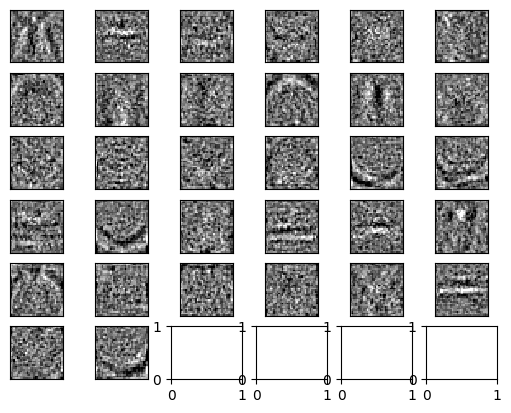

In [87]:
best_test_acc = np.max(test_acc_history_total)
print(f"Best test accuracy: {best_test_acc:.4f}")

# Save the results
result_dict = {
    'name': model_name,
    'loss_curve': average_train_loss,
    'train_acc_curve': average_train_acc,
    'val_acc_curve': average_valid_acc,
    'test_acc': best_test_acc,
    'weights': best_weights
}

# Save the results to a file
filename = 'results/question_3_' + model_name.replace(' ', '_') + '.pkl'
with open(filename, 'wb') as f:
    pickle.dump(result_dict, f)

took_time = time.time() - model_init_time
print(f"All process for {model_name}: {took_time:.4f} s")

visualizeWeights(best_weights, save_dir='results/',
                 filename='question_3_weights_' + model_name.replace(' ', '_'))

took_time = time.time() - init_time
print(f"All process: {took_time:.4f} s")